<a href="https://colab.research.google.com/github/CamilleBre/FV_home-assignment/blob/master/mymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tomato allergies

This notebook builds and trains a Deep Learning model to detect whether a meal includes a specific aliment (ex: tomato).

# Loading packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


# TensorFlow
import tensorflow as tf


# Helper libraries
import json
import csv 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# File management

To import the dataset from your Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Import data

## Labels 
*   *label_mapping.csv*: the names of each class (available both in English and French)

*   *img_annotations.json*: the image annotations with class id

In [0]:
# Import the names of each class in a dict
dict_id_labels = dict()
with open("/content/drive/My Drive/data/label_mapping.csv") as f:
    reader = csv.reader(f)
    next(reader) 
    for id, fr, en in reader:
        dict_id_labels[id] = fr

# Import the image annotations in a dict
with open('/content/drive/My Drive/data/img_annotations.json', 'rb') as f:
    img_annotations = json.load(f)

# Create a new dict containing only useful information from img_annotation (img:labels)
img_with_id=dict()
for key in img_annotations.keys():
    img_with_id[key] = [d['id'] for d in img_annotations[key]]


### Create labels for a specific aliment

As we are to detect whether an image contains or not a specific aliment, the labels used for the model will be binary digits: 1 if the aliment is present, 0 if not.

In [0]:
aliment = ["tomate","Tomate","bolognaise"]
# An aliment can be referenced under different labels in the dataset. In this example,
# the specific aliment we are interest in is tomato. By exploring the dataset we can 
# see the labels "tomate(s)" or "Tomate(s)" are presents. To improve the 
# classification, we can also add products known to  contain this aliment 
# ("bolognaise" for example here).  


# List all labels in the dataset containing one of the element of the list aliment and not containing "sans"
list_id_aliment = [key for key,value in dict_id_labels.items() if (any(al in value for al in aliment) and 'sans' not in value)]

# Attribute to each image of the dataset a label 1 if contains tomato, 0 if not.
list_labels = [any(item in img_with_id[name_img] for item in list_id_aliment) for name_img in img_with_id.keys()]
list_labels = np.array(list_labels).astype(int)

# Images

Define some parameters for the loader:

In [0]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

Load images as arrays dim (IMG_HEIGHT,IMG_WIDTH,3). Scale these values to a range of 0 to 1 before feeding them to the neural network model. 


In [0]:
images_path = "/content/drive/My Drive/data/imgs"

# Format the images into appropriately pre-processed floating point tensors 
loaded_images =[np.array(Image.open(images_path+"/"+item).resize((IMG_HEIGHT,IMG_WIDTH)))/255 for item in img_with_id.keys()]


# Build the model

Here the model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a relu activation function. The model outputs class probabilities based on binary classification by the sigmoid activation function. (From TensorFlow [Image Classification tutorial](https://www.tensorflow.org/tutorials/images/classification?hl=fr) )

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Compile 

We use the ADAM optimizer and binary cross entropy loss function to compile the model.

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Train the model

We use our dataset containing 3000 images to train the model. The dataset is split in a training and a test sets.

## Some parameters for training


In [0]:
# Percentage of images of the dataset used for validation 
RATIO_TEST = 0.2

# Number of iterations 
EPOCHS = 15

## Create checkpoints

In [0]:
# Create a callback that saves the model's weights
checkpoint_path = "/content/drive/My Drive/ckp"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)


## Train

In [11]:
# Train the model with the callback 
history = model.fit(np.array(loaded_images), list_labels, validation_split=RATIO_TEST, epochs=EPOCHS, callbacks=[cp_callback])

Train on 2400 samples, validate on 600 samples
Epoch 1/15
2368/2400 [============================>.] - ETA: 1s - loss: 0.6019 - acc: 0.8041
Epoch 00001: saving model to /content/drive/My Drive/ckp
2400/2400 [==============================] - 125s 52ms/sample - loss: 0.5978 - acc: 0.8054 - val_loss: 0.4948 - val_acc: 0.7917
Epoch 2/15
2368/2400 [============================>.] - ETA: 1s - loss: 0.3975 - acc: 0.8273
Epoch 00002: saving model to /content/drive/My Drive/ckp
2400/2400 [==============================] - 124s 52ms/sample - loss: 0.3987 - acc: 0.8267 - val_loss: 0.4094 - val_acc: 0.7967
Epoch 3/15
2368/2400 [============================>.] - ETA: 1s - loss: 0.3491 - acc: 0.8374
Epoch 00003: saving model to /content/drive/My Drive/ckp
2400/2400 [==============================] - 124s 52ms/sample - loss: 0.3491 - acc: 0.8383 - val_loss: 0.4194 - val_acc: 0.8117
Epoch 4/15
2368/2400 [============================>.] - ETA: 1s - loss: 0.3259 - acc: 0.8535
Epoch 00004: saving model 

# Visualize training results

Now visualize the results after training the network.

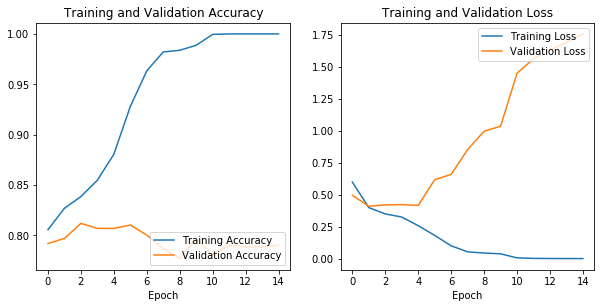

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(EPOCHS)


plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.title('Training and Validation Loss')
plt.show()


# Evaluation 

Check the success condition: is the error rate < 0.05 

*NB : As the point is to detect an aliment a user can be allergic to, error rate seems not to be the more adapted measure for evalution here. It's important to avoid False Negatives (i.e classify a meal as not containing tomato if there is actually tomato inside). Minimizing the False Negative rate could be a more relevant success evaluation in this case.*


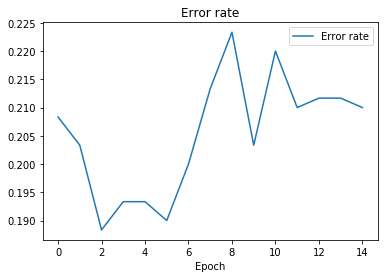

Final error rate :0.0


In [13]:
plt.plot(epochs_range, [1-acc for acc in val_acc], label='Error rate')
plt.legend(loc='upper right')
plt.title('Error rate')
plt.xlabel("Epoch")
plt.show()
print ("Final error rate :" + str(1-acc[EPOCHS-1]))

# Make predictions 

We select N_RAND random images in the dataset and use the model to predict if they contain tomato or not. We then have a look at the images which are predicted to contain tomato. 

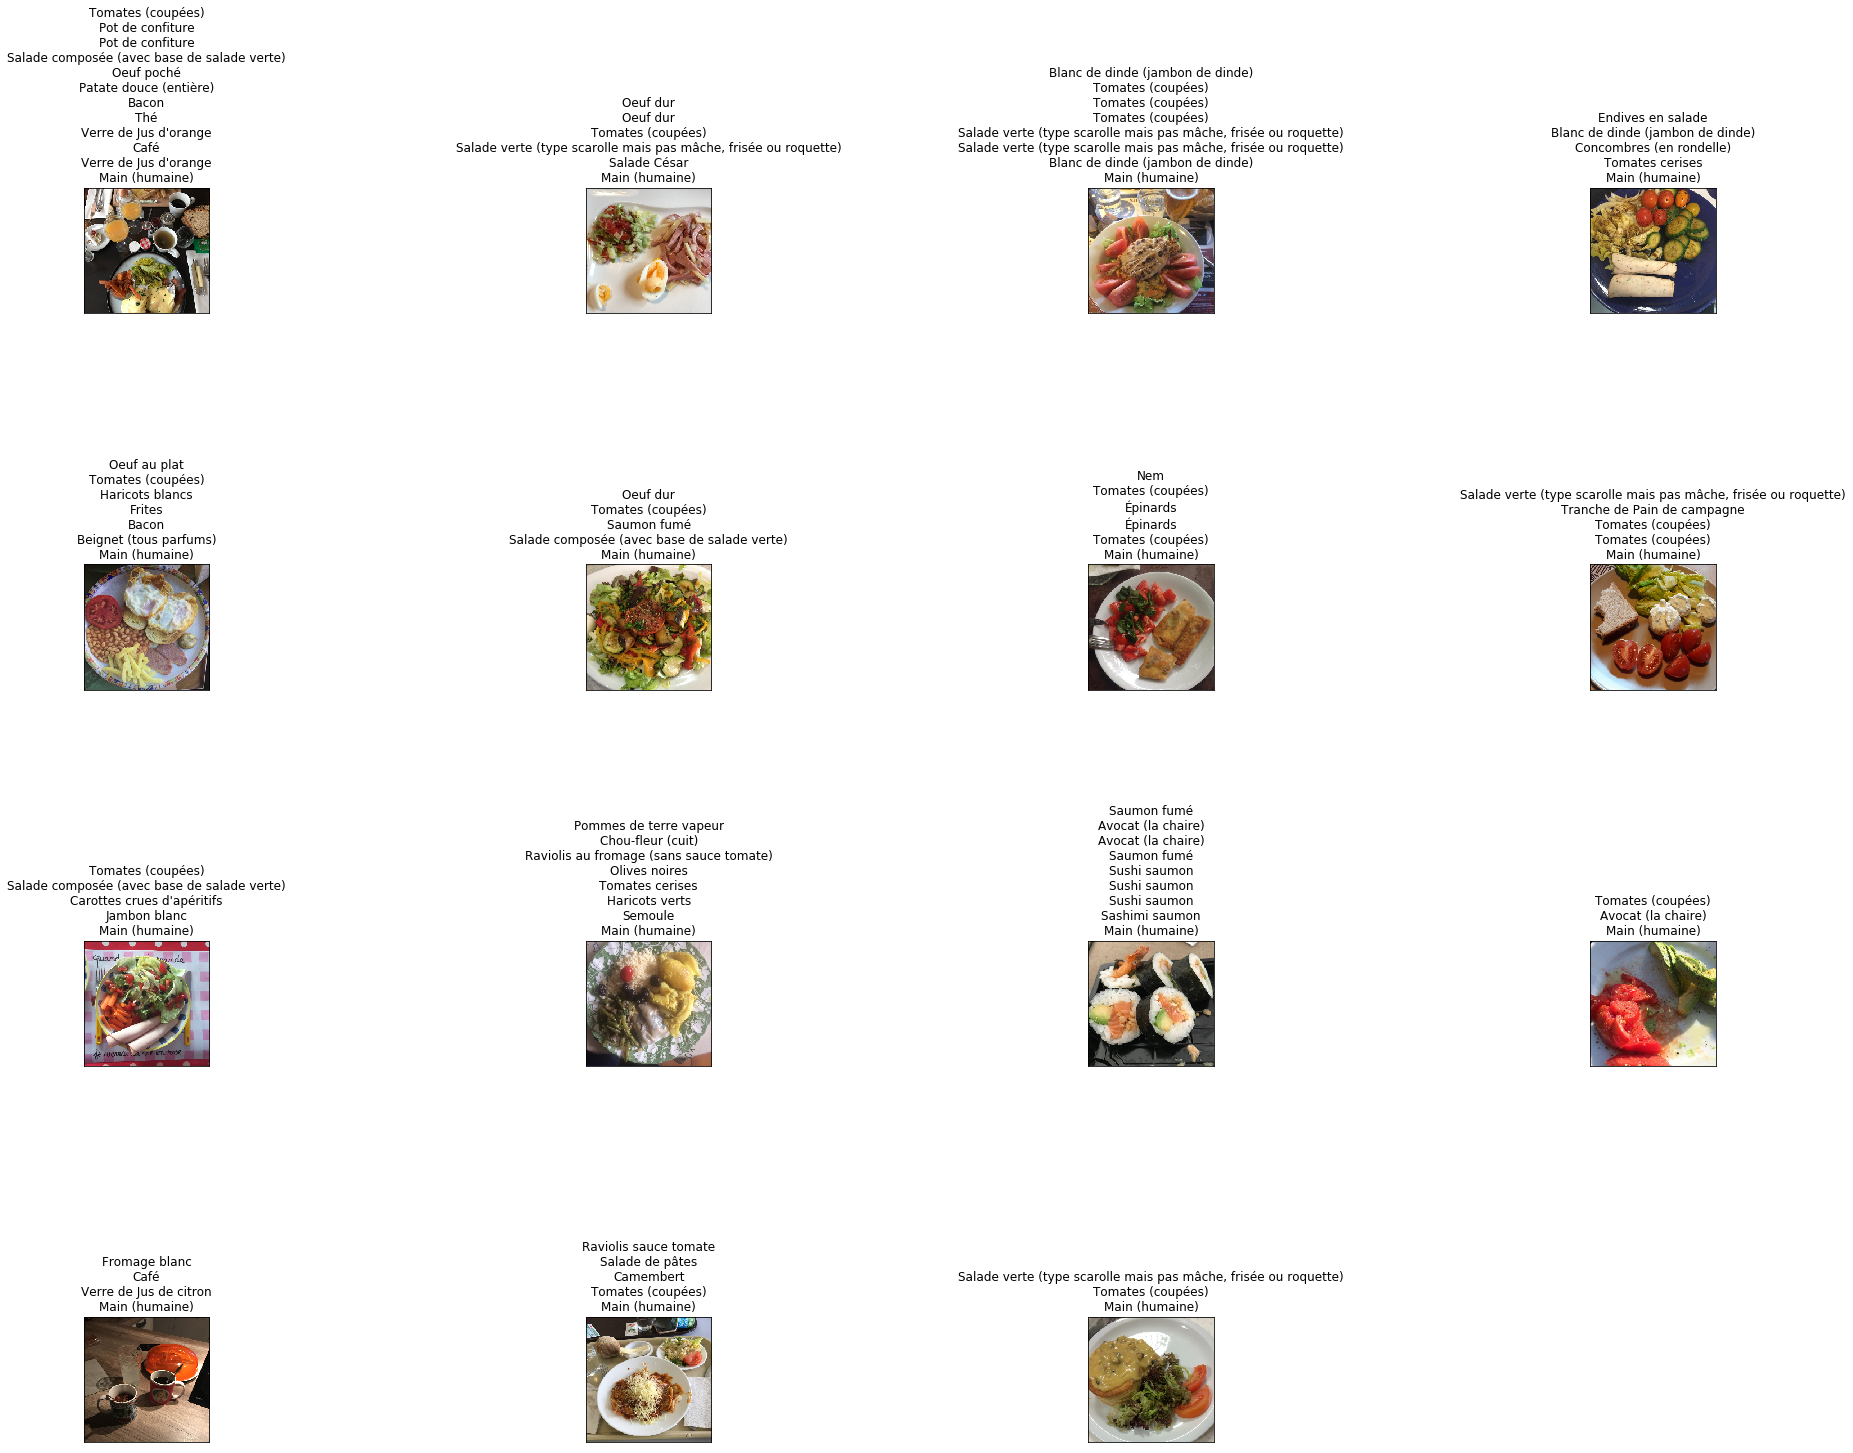

In [14]:
N_RAND = 100

# Selected N_RAND images and make predictions with the model
list_rand = np.random.randint(len(img_with_id)-1, size = N_RAND)
predictions = model.predict(np.array([loaded_images[x] for x in list_rand])) 

listnum_predicted_aliment = [list_rand[i] for i in range(N_RAND) if predictions[i]>0.99]
imgs_predicted_aliment=[list(img_with_id.keys())[x] for x in listnum_predicted_aliment]

# Plot images categorized with tomato
plt.figure(figsize=(30,30))
for i in range(len(imgs_predicted_aliment)):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(loaded_images[listnum_predicted_aliment[i]], cmap=plt.cm.binary)
    plt.title('\n'.join(map(str, [dict_id_labels[id] for id  in img_with_id[imgs_predicted_aliment[i]]])))
    plt.subplots_adjust(wspace = 2, hspace = 2 )
plt.show()